<a href="https://colab.research.google.com/github/TanmasLeigh/alx-pre_course/blob/main/Updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
                 0       1       2       3       4  5
0  20000530 172700  0.9302  0.9302  0.9302  0.9302  0
1  20000530 173500  0.9304  0.9305  0.9304  0.9305  0
2  20000530 173800  0.9304  0.9304  0.9303  0.9303  0
3  20000530 174300  0.9301  0.9301  0.9300  0.9300  0
4  20000530 174400  0.9298  0.9298  0.9297  0.9297  0


<ipython-input-5-fb0164b9a234>:53: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_range = pd.date_range(start=data.index.min(), end=data.index.max(), freq='1T')


Missing Timestamps:
DatetimeIndex(['2000-05-30 17:28:00', '2000-05-30 17:29:00',
               '2000-05-30 17:30:00', '2000-05-30 17:31:00',
               '2000-05-30 17:32:00', '2000-05-30 17:33:00',
               '2000-05-30 17:34:00', '2000-05-30 17:36:00',
               '2000-05-30 17:37:00', '2000-05-30 17:39:00',
               ...
               '2021-12-30 23:48:00', '2021-12-31 00:25:00',
               '2021-12-31 00:43:00', '2021-12-31 00:48:00',
               '2021-12-31 00:52:00', '2021-12-31 01:58:00',
               '2021-12-31 02:17:00', '2021-12-31 13:43:00',
               '2021-12-31 14:07:00', '2021-12-31 14:36:00'],
              dtype='datetime64[ns]', length=4073577, freq=None)


<ipython-input-5-fb0164b9a234>:69: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_range = pd.date_range(start=data.index.min(), end=data.index.max(), freq='T')


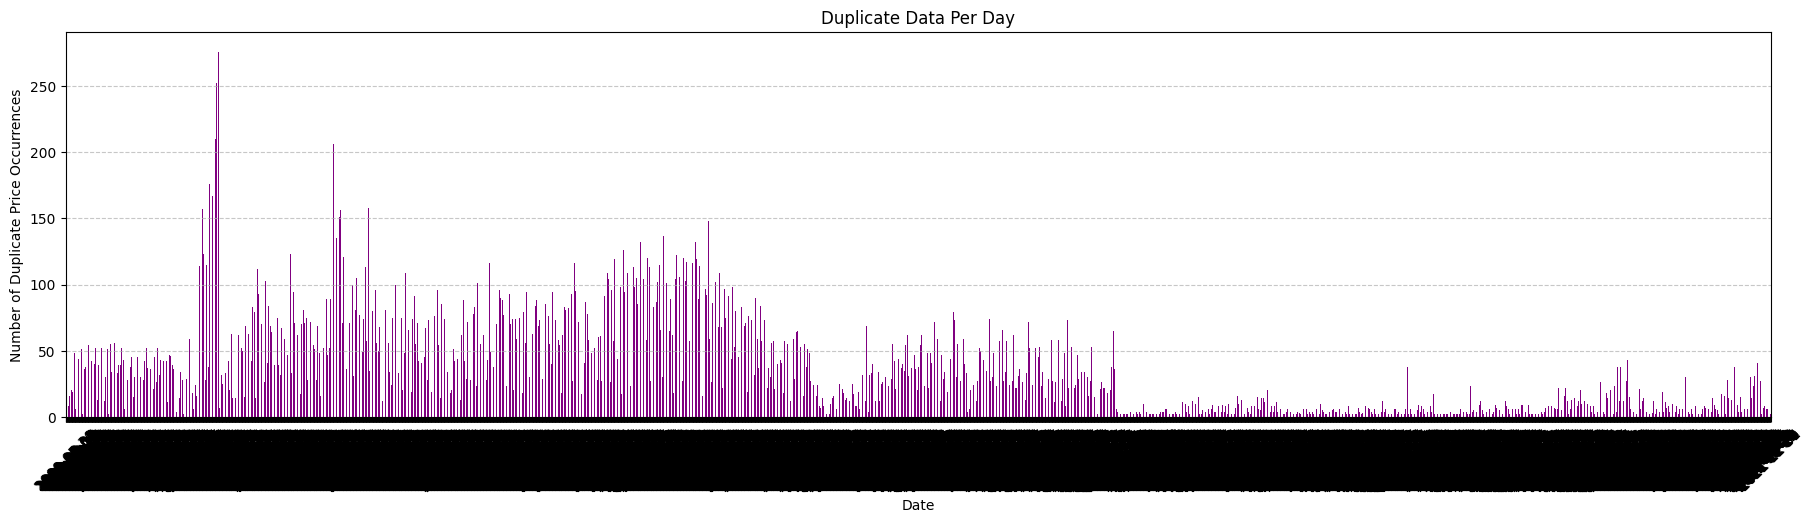

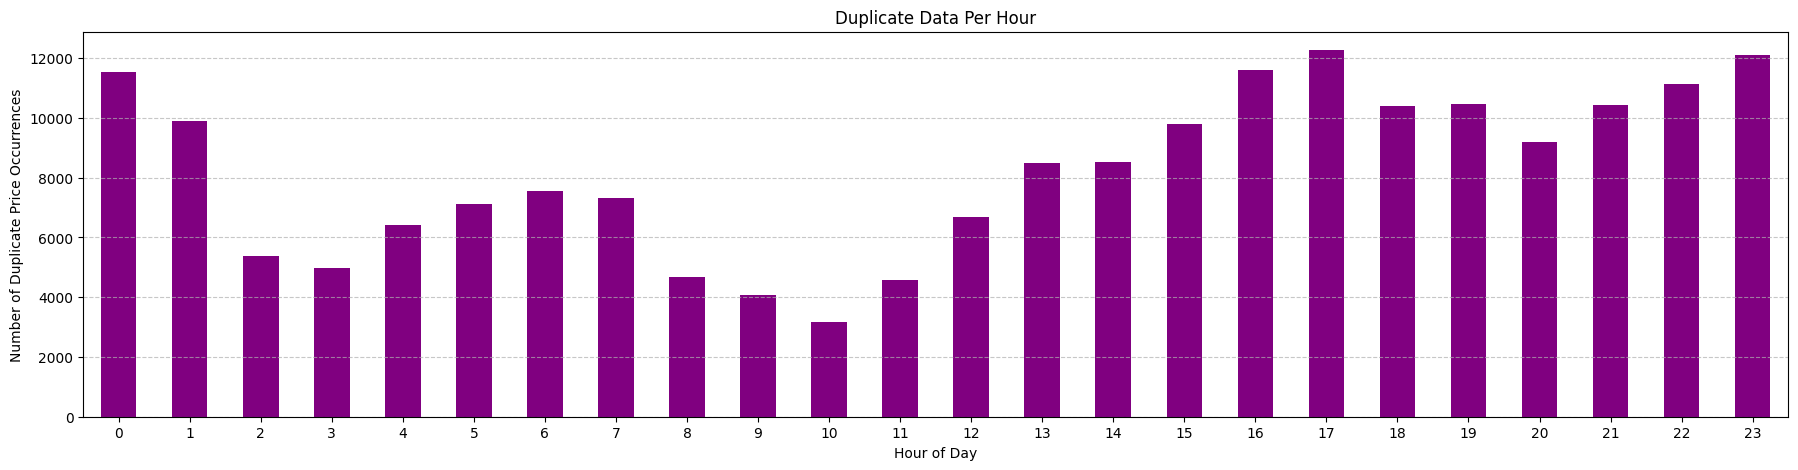

In [5]:
import pandas as pd
import numpy as np
import os
from scipy import stats
from sklearn.cluster import DBSCAN
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.stats.diagnostic import het_arch
from scipy.stats import jarque_bera
from statsmodels.tsa.stattools import adfuller



# Define the file path pattern (adjust if needed)
drive.mount('/content/drive')
base_path = "/content/drive/MyDrive/Gamma"

# List to store DataFrames
data_frames = []

# Loop through years 2010 to 2021
for year in range(2000, 2022):
    file_path = os.path.join(base_path, f'DAT_ASCII_EURUSD_M1_{year}.csv')

    # Read CSV file (adjust parameters if needed)
    df = pd.read_csv(file_path, header=None, sep=';')

    # Append to list
    data_frames.append(df)

# Concatenate all DataFrames into one
data = pd.concat(data_frames, ignore_index=True)

# Display first few rows to confirm
print(data.head())
data.tail()
data.shape
# Rename columns for clarity
data.columns = ['DateTime', 'Open', 'High', 'Low', 'Close', 'Volume']
data.tail(4)

# Convert 'DateTime' to datetime format
data['DateTime'] = pd.to_datetime(data['DateTime'], format='%Y%m%d %H%M%S')
data.tail()
data.set_index('DateTime', inplace=True)
data
# Ensure 'DateTime' is the index
data.index = pd.to_datetime(data.index)

# Generate a full range of 1-minute timestamps
full_range = pd.date_range(start=data.index.min(), end=data.index.max(), freq='1T')
# Find missing timestamps
missing_timestamps = full_range.difference(data.index)   # Identifies missing timestamps

# Display missing timestamps
print(f"Missing Timestamps:\n{missing_timestamps}")

data.iloc[35:45]
data.iloc[50:60]
missing_timestamps.shape
# Convert missing timestamps to a DataFrame
missing_df = pd.DataFrame(missing_timestamps, columns=['DateTime'])
missing_df['indicator'] = 1
missing_df
# Generate a complete time range with 1-minute frequency
# Instead of data['DateTime'], use data.index to access the DateTime values
full_range = pd.date_range(start=data.index.min(), end=data.index.max(), freq='T')
# Create a dataframe from the complete time range
complete_df = pd.DataFrame(full_range, columns=['DateTime'])

# Merge the original dataframe with the complete time range
combined_df = pd.merge(complete_df, data, on='DateTime', how='left')
# Merge the missing dataframe with the combined dataframe
combined_df = pd.merge(combined_df, missing_df, on='DateTime', how='left')
combined_df
# Fill the 'indicator' column: 0 for non-missing, 1 for missing
combined_df['indicator'] = combined_df['indicator'].fillna(0).astype(int)

# Sort by DateTime (optional)
combined_df = combined_df.sort_values(by='DateTime').reset_index(drop=True)
combined_df.shape
#######    EXPLANATORY DATA ANALYSIS   #######
####   DUPLICATED DATA ANALYSIS  #####
# Ensure DateTime is in datetime format
combined_df['DateTime'] = pd.to_datetime(combined_df['DateTime'])

# Identify duplicated consecutive OHLC prices
dup_consecutive = combined_df[['Open', 'High', 'Low', 'Close']].eq(combined_df[['Open', 'High', 'Low', 'Close']].shift(-1)).all(axis=1) | \
                  combined_df[['Open', 'High', 'Low', 'Close']].eq(combined_df[['Open', 'High', 'Low', 'Close']].shift(1)).all(axis=1)

dup_df = combined_df[dup_consecutive]

# Group duplicate occurrences by date
dup_per_day = dup_df.groupby(dup_df['DateTime'].dt.date).size()

#  Group by hour and count occurrences of duplicate data
dup_per_hour = dup_df.groupby(dup_df['DateTime'].dt.hour).size()

# Plot duplicate occurrences per day
plt.figure(figsize=(22, 5))
dup_per_day.plot(kind='bar', color='purple')
plt.title('Duplicate Data Per Day')
plt.xlabel('Date')
plt.ylabel('Number of Duplicate Price Occurrences')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Plot the bar chart for duplicate data occurrences per hour
plt.figure(figsize=(22, 5))
dup_per_hour.plot(kind='bar', color='purple')
plt.title('Duplicate Data Per Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Duplicate Price Occurrences')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()



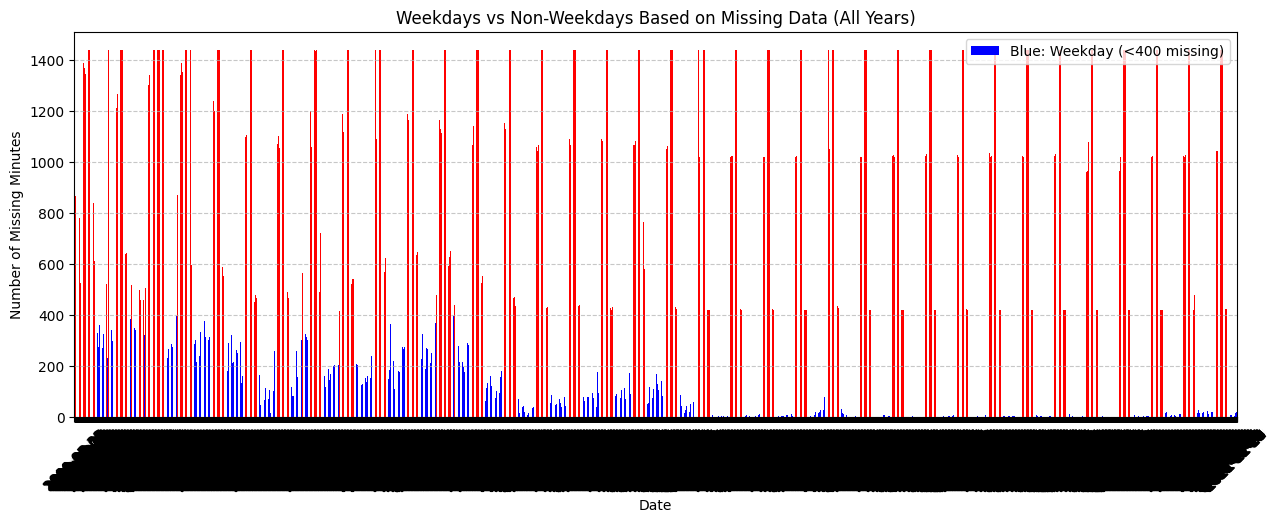

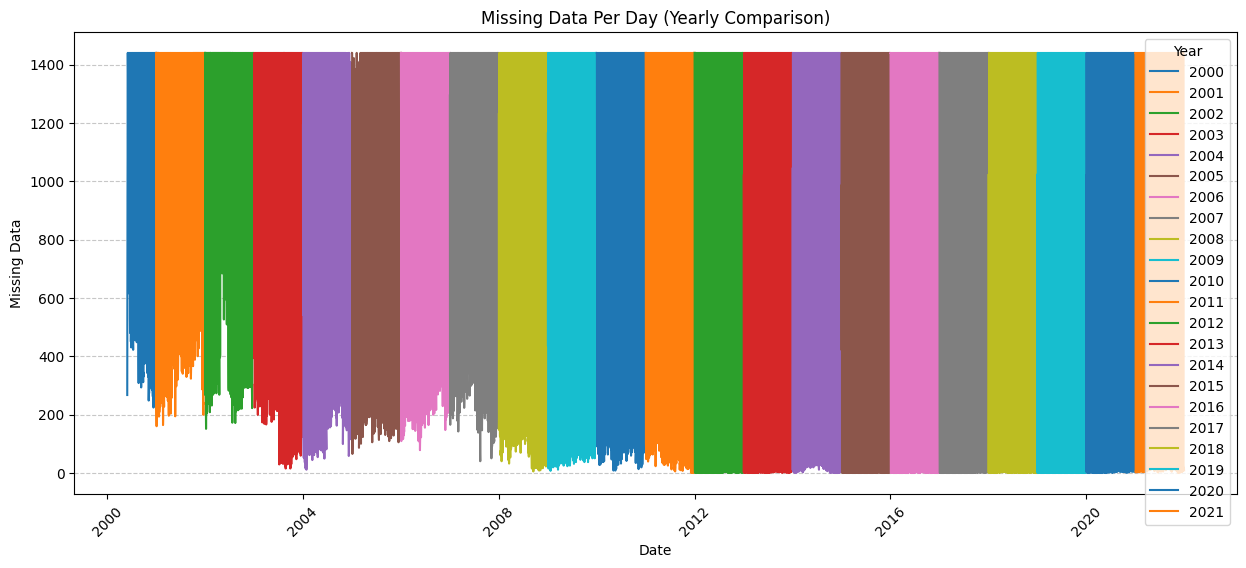

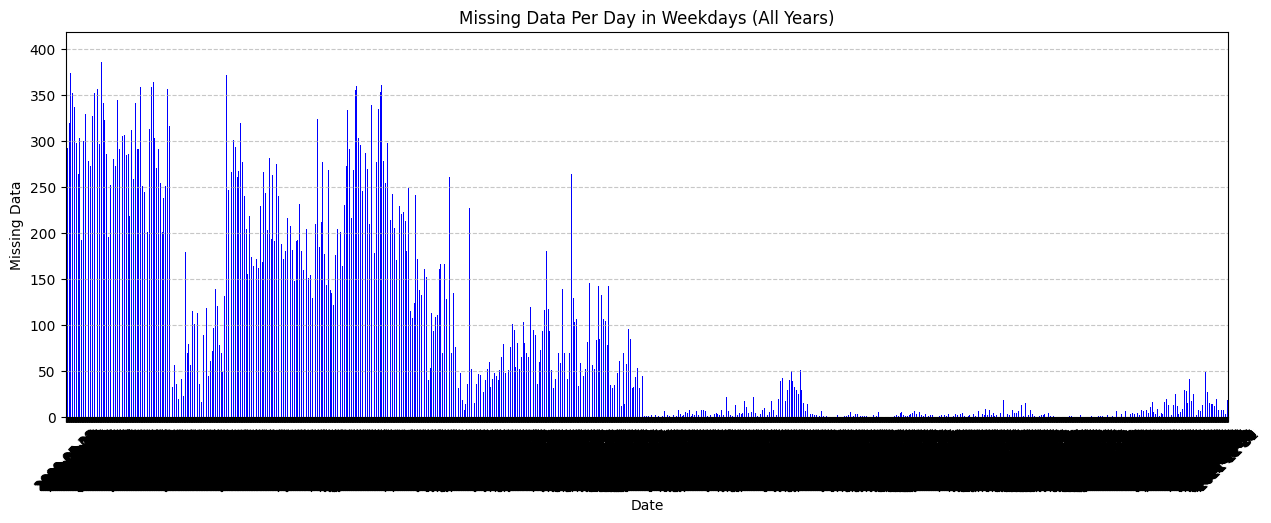

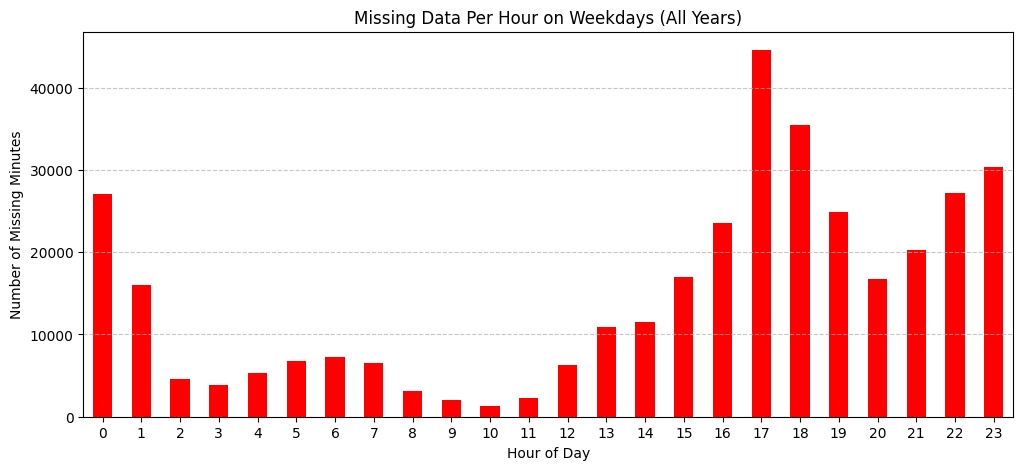

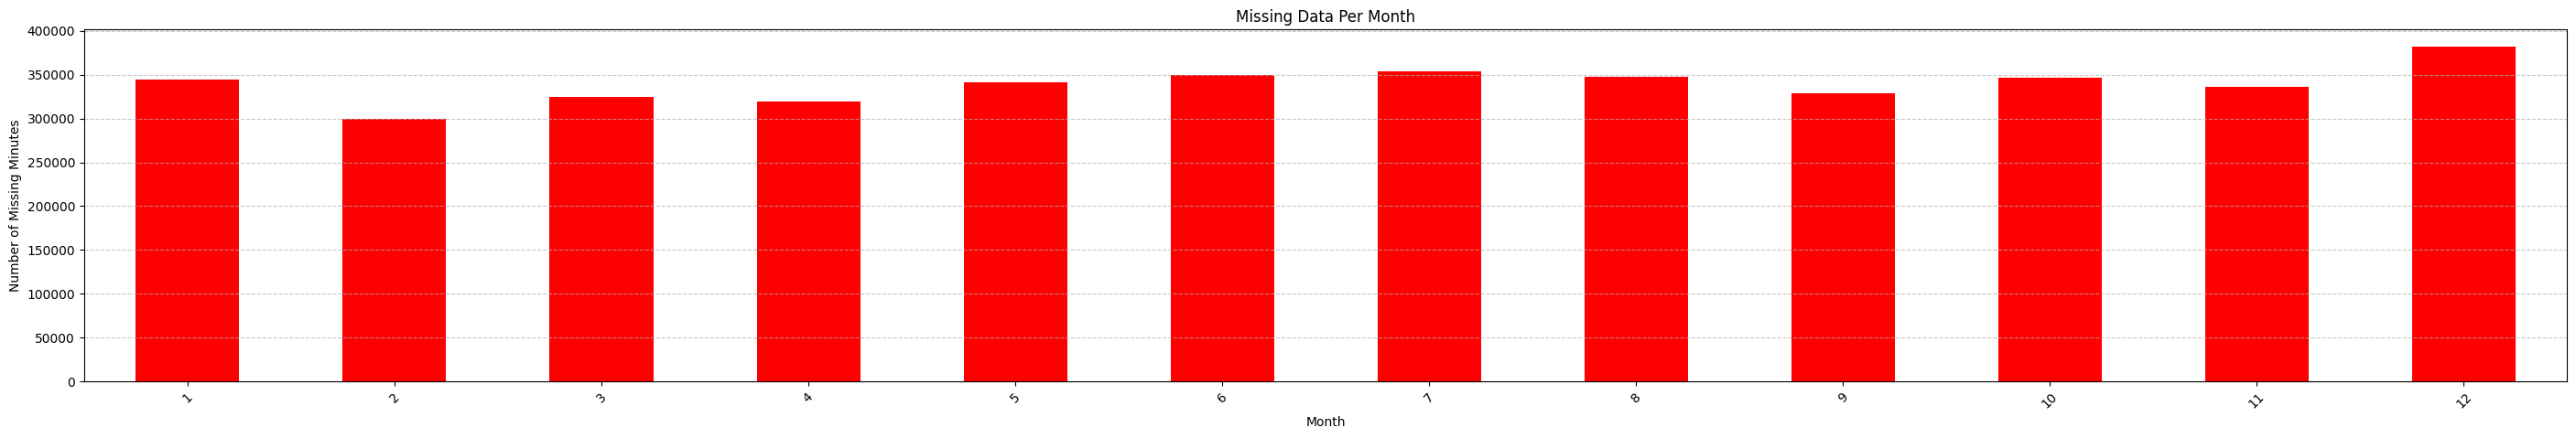

DateTime
1     344618
2     299442
3     324297
4     319527
5     340878
6     349312
7     353369
8     347280
9     329058
10    346928
11    336473
12    382395
Name: indicator, dtype: int64


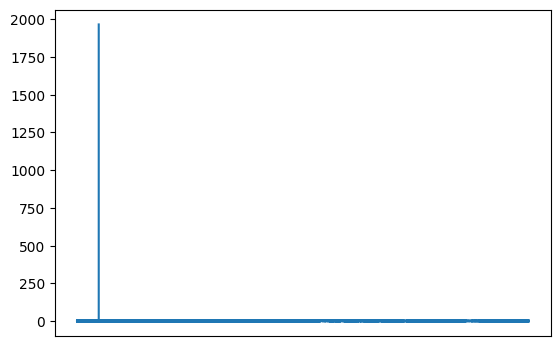

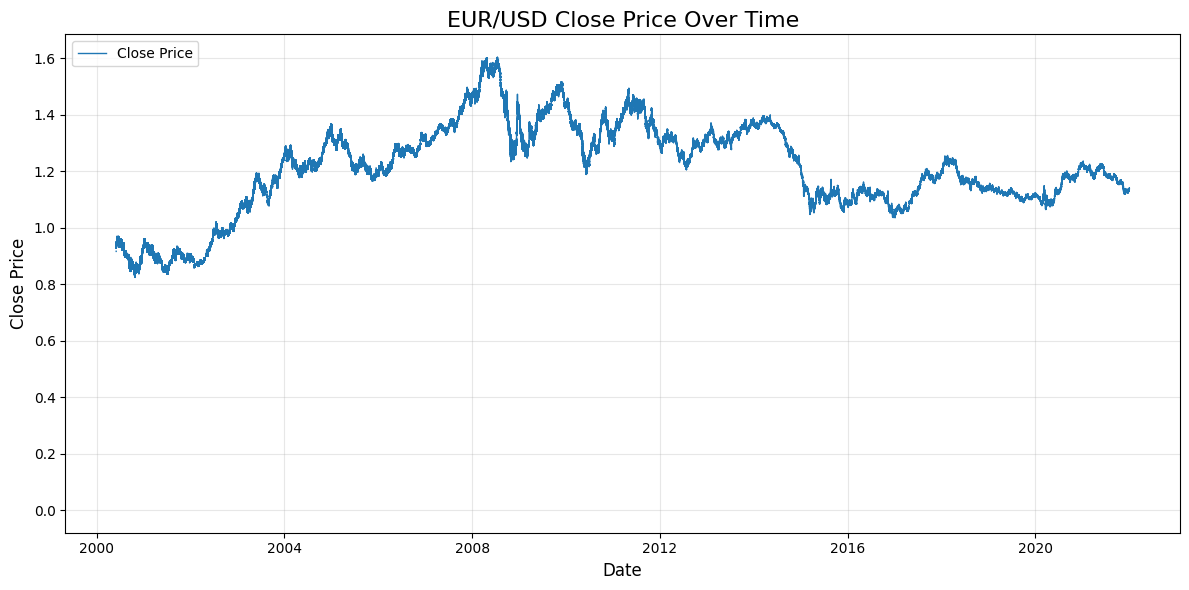

<ipython-input-6-0b9ebbbb3ebd>:245: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  ohlc_data = data.resample(resample_str).agg({
<ipython-input-6-0b9ebbbb3ebd>:256: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  grouped_counts = ohlc_data.resample(f'{timeframe}T').size()  # Actual data points per group
<ipython-input-6-0b9ebbbb3ebd>:197: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  period_counts = ohlc_data.resample(resample_str_timeframe).size()  # Count of data points per timeframe
<ipython-input-6-0b9ebbbb3ebd>:198: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  rvol_data = ohlc_data.resample(resample_str_timeframe).agg({'V': 'sum'})
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = ge

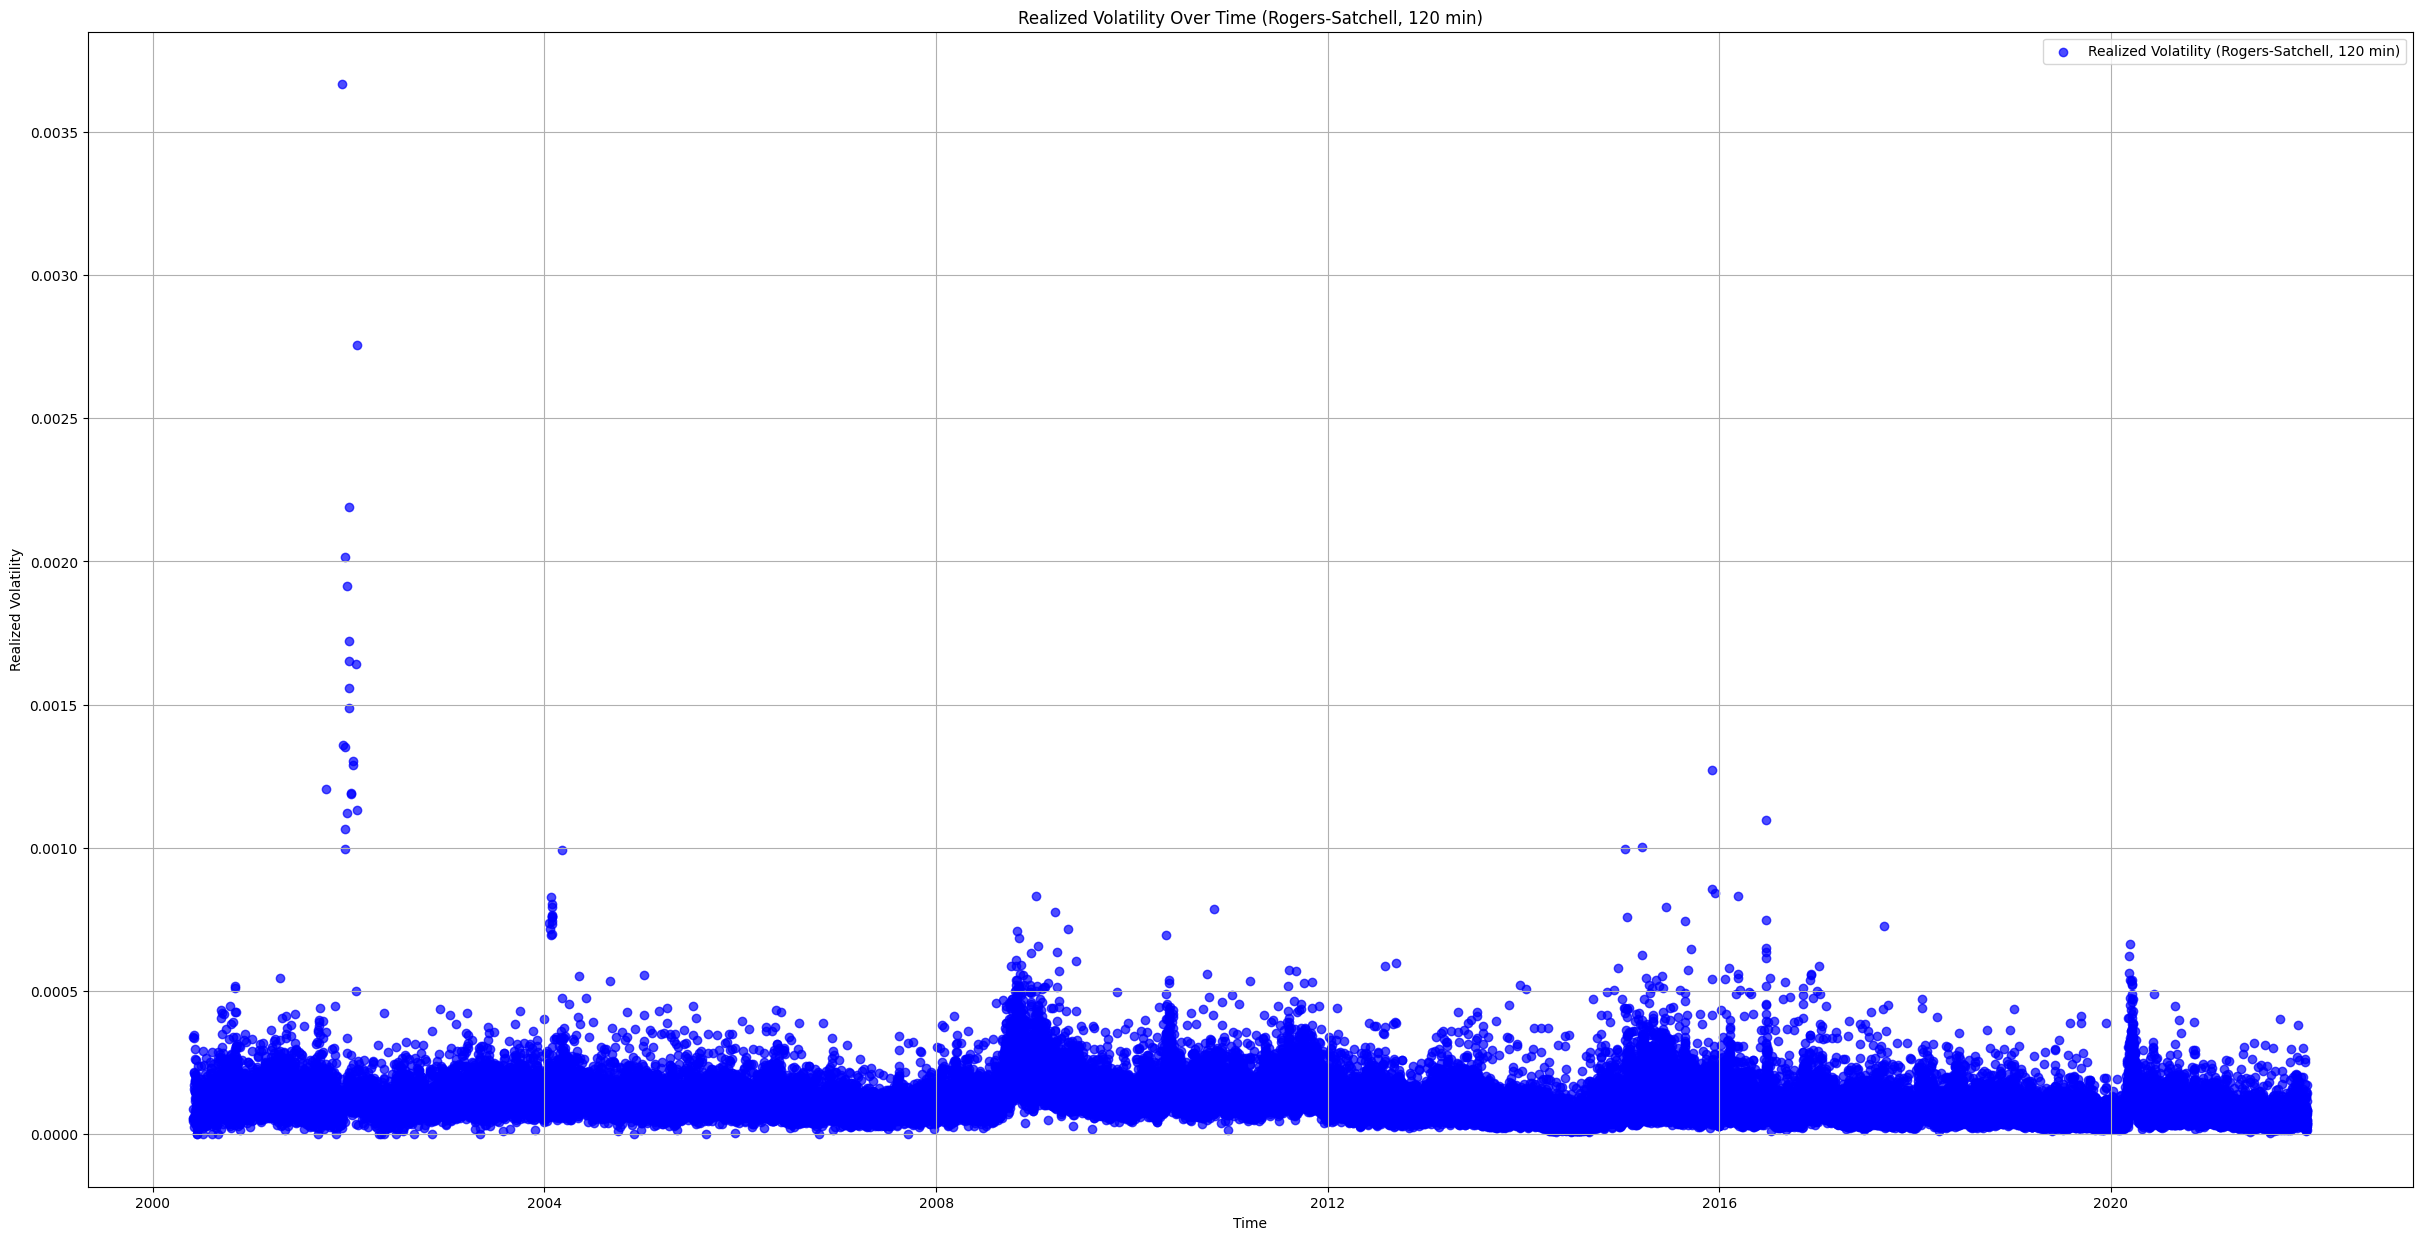

<ipython-input-6-0b9ebbbb3ebd>:245: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  ohlc_data = data.resample(resample_str).agg({
<ipython-input-6-0b9ebbbb3ebd>:256: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  grouped_counts = ohlc_data.resample(f'{timeframe}T').size()  # Actual data points per group
<ipython-input-6-0b9ebbbb3ebd>:197: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  period_counts = ohlc_data.resample(resample_str_timeframe).size()  # Count of data points per timeframe
<ipython-input-6-0b9ebbbb3ebd>:198: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  rvol_data = ohlc_data.resample(resample_str_timeframe).agg({'V': 'sum'})
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = ge

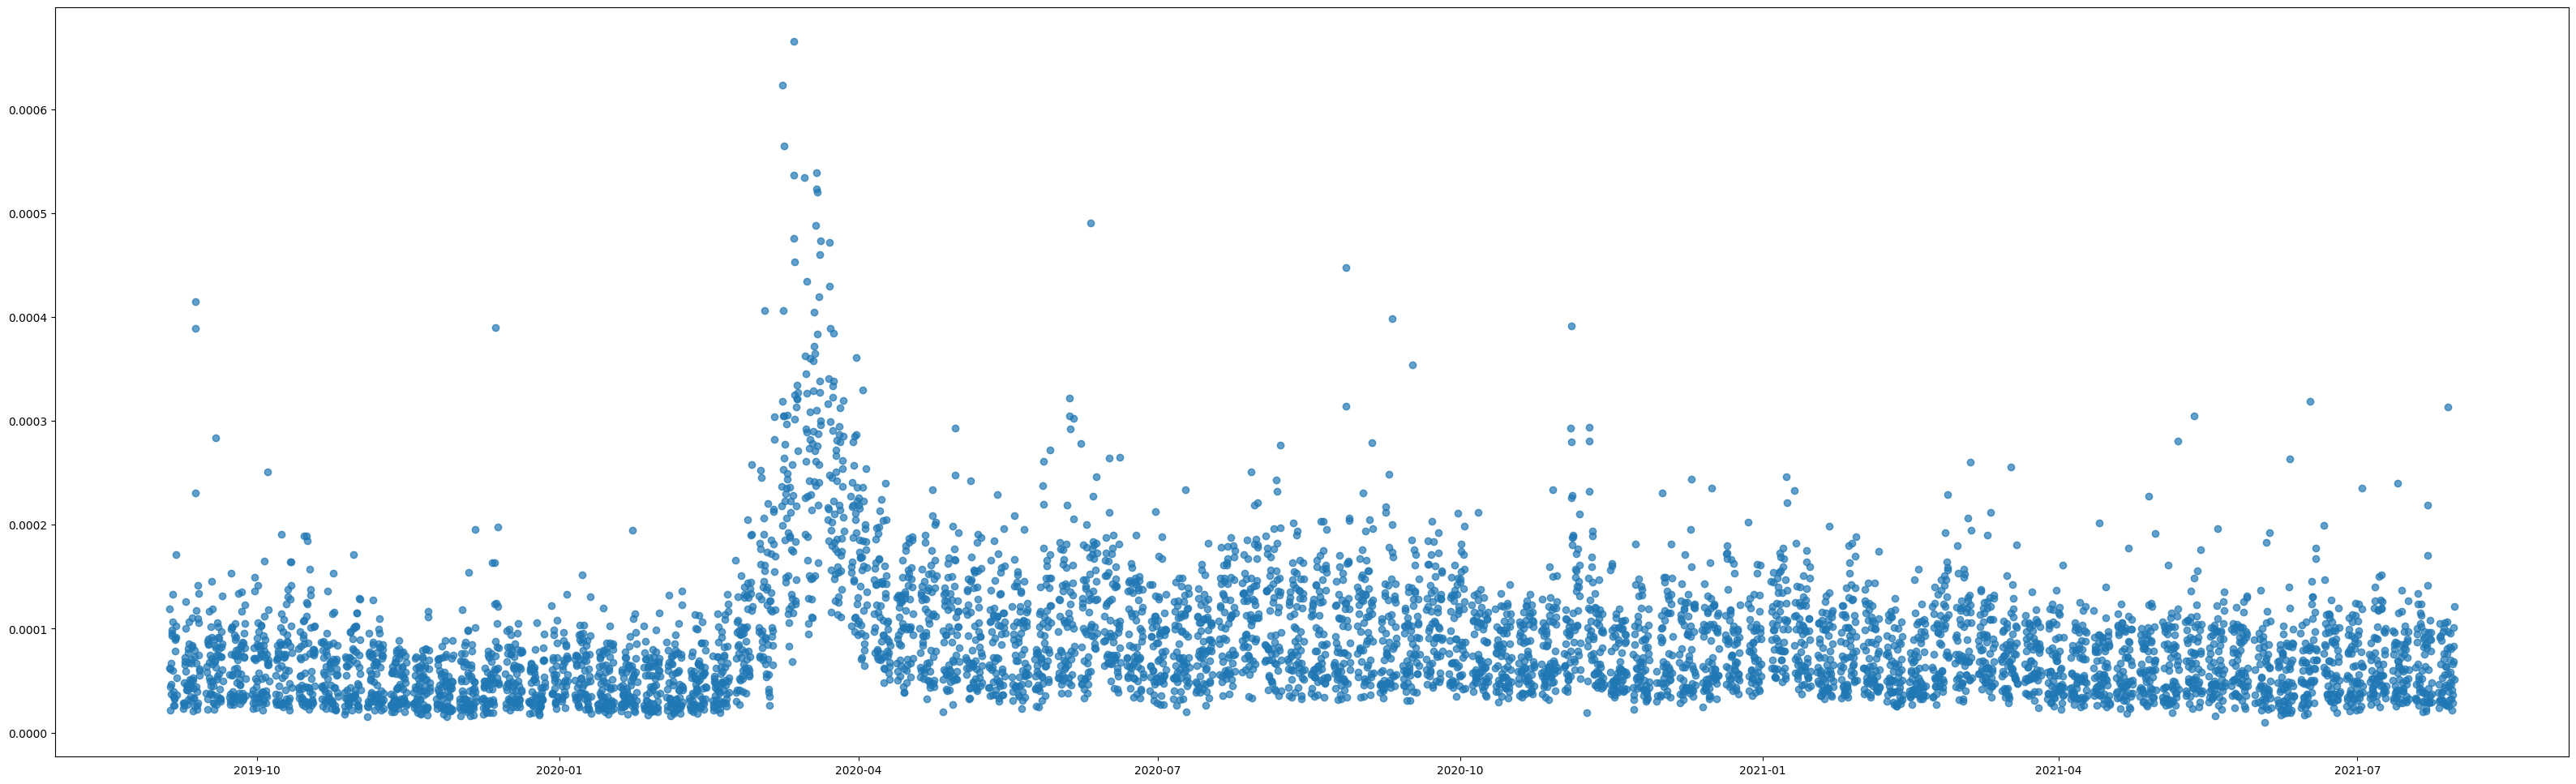

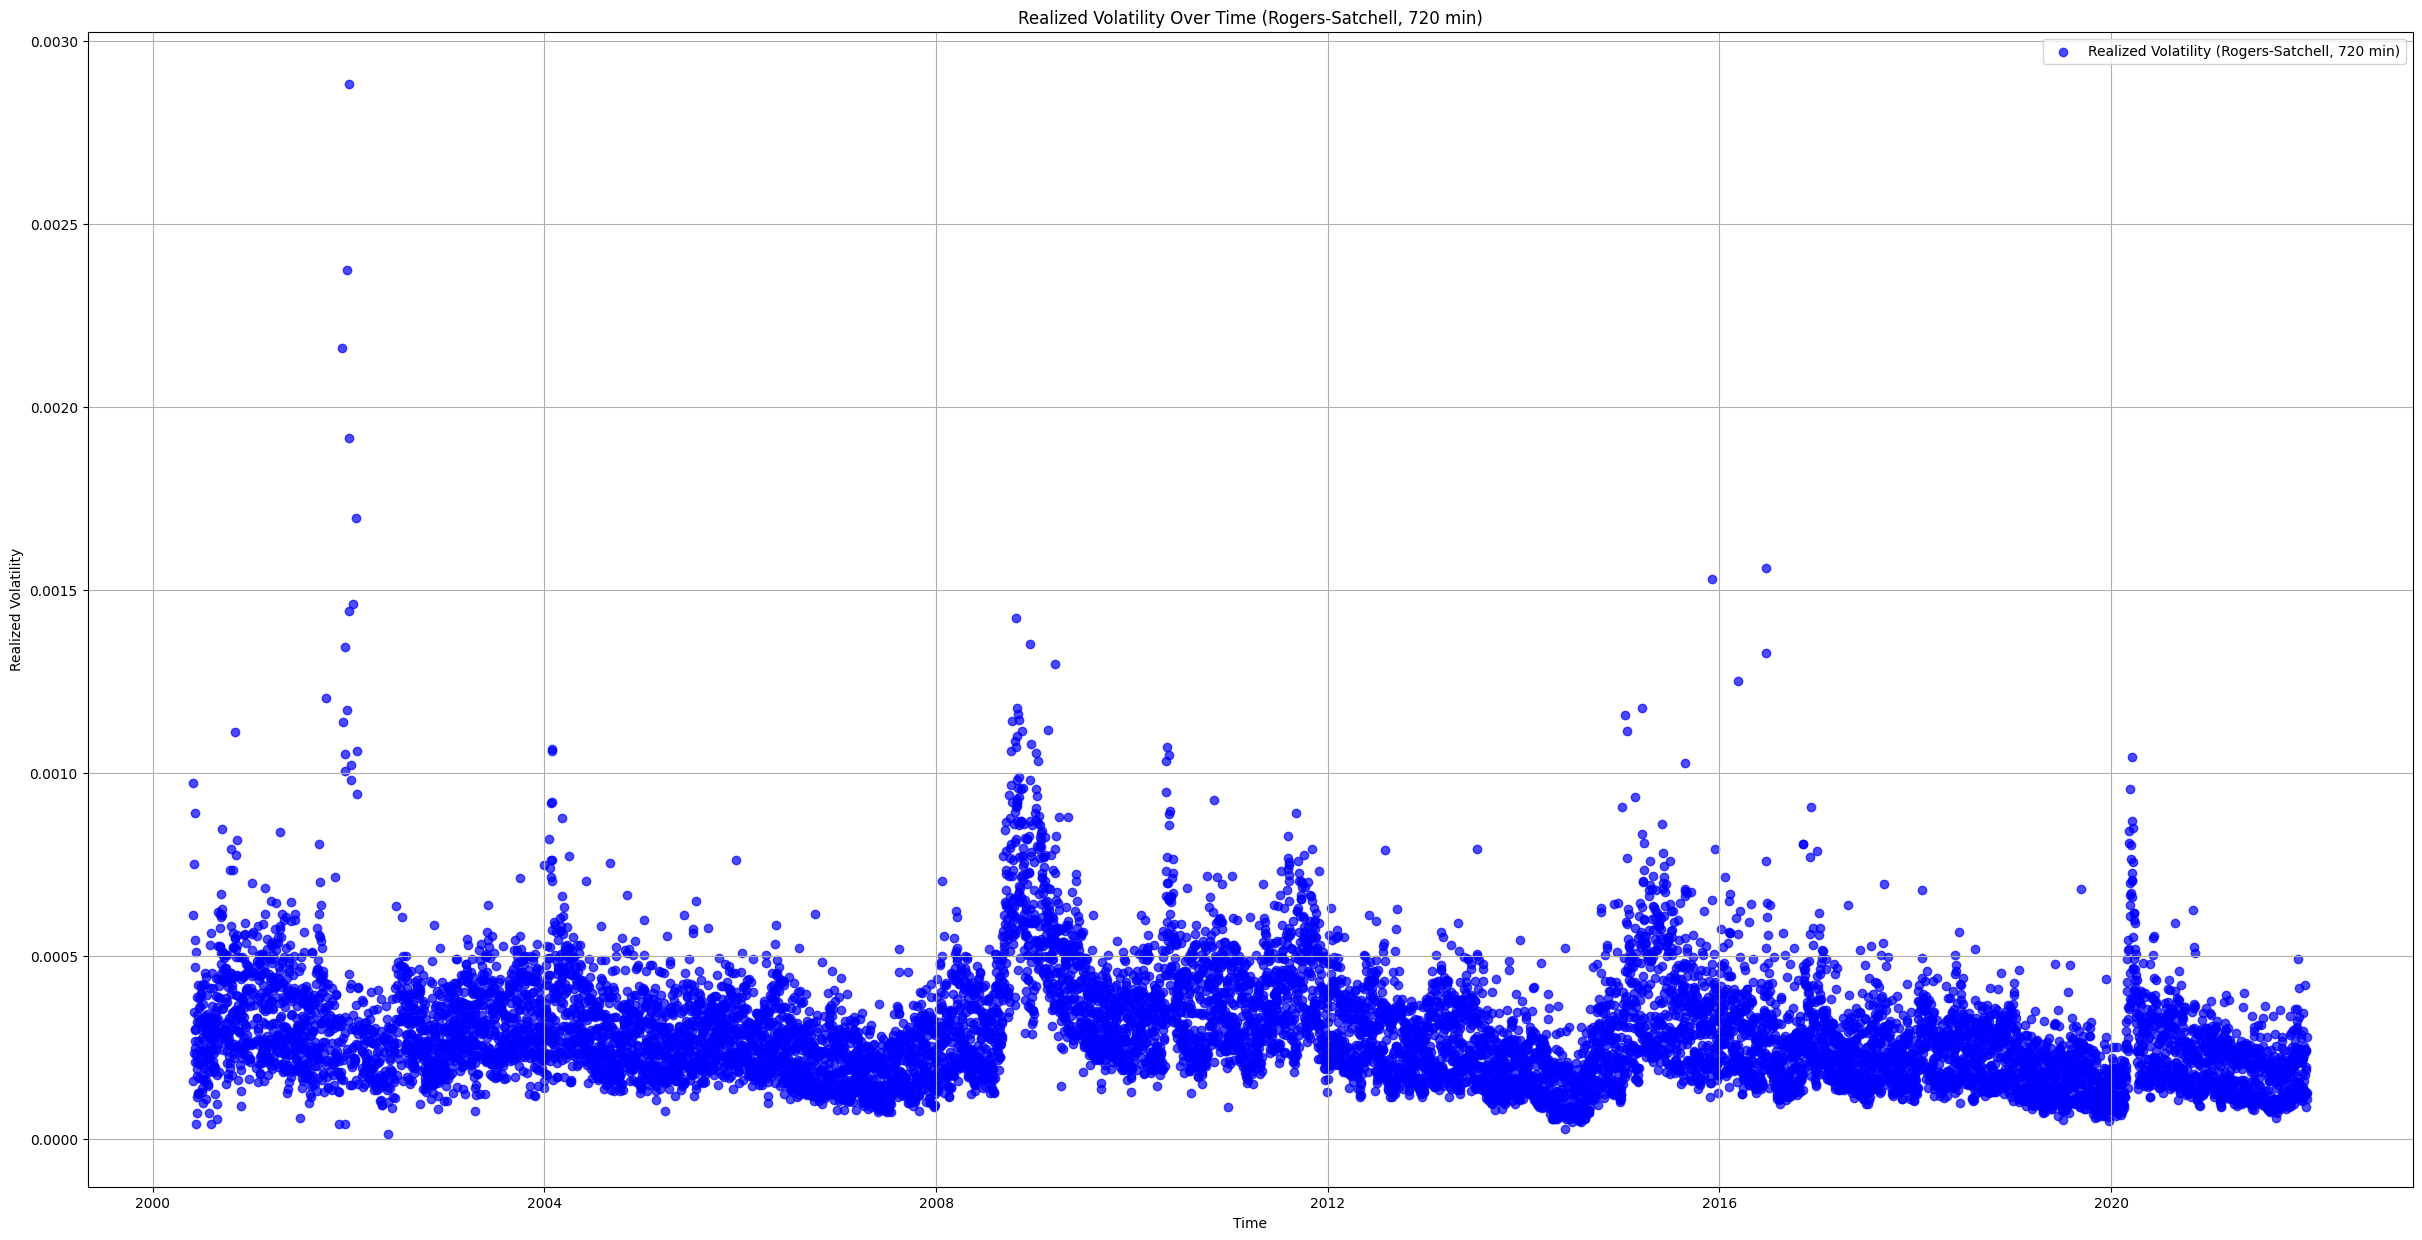

<ipython-input-6-0b9ebbbb3ebd>:245: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  ohlc_data = data.resample(resample_str).agg({
<ipython-input-6-0b9ebbbb3ebd>:256: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  grouped_counts = ohlc_data.resample(f'{timeframe}T').size()  # Actual data points per group
<ipython-input-6-0b9ebbbb3ebd>:197: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  period_counts = ohlc_data.resample(resample_str_timeframe).size()  # Count of data points per timeframe
<ipython-input-6-0b9ebbbb3ebd>:198: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  rvol_data = ohlc_data.resample(resample_str_timeframe).agg({'V': 'sum'})
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = ge

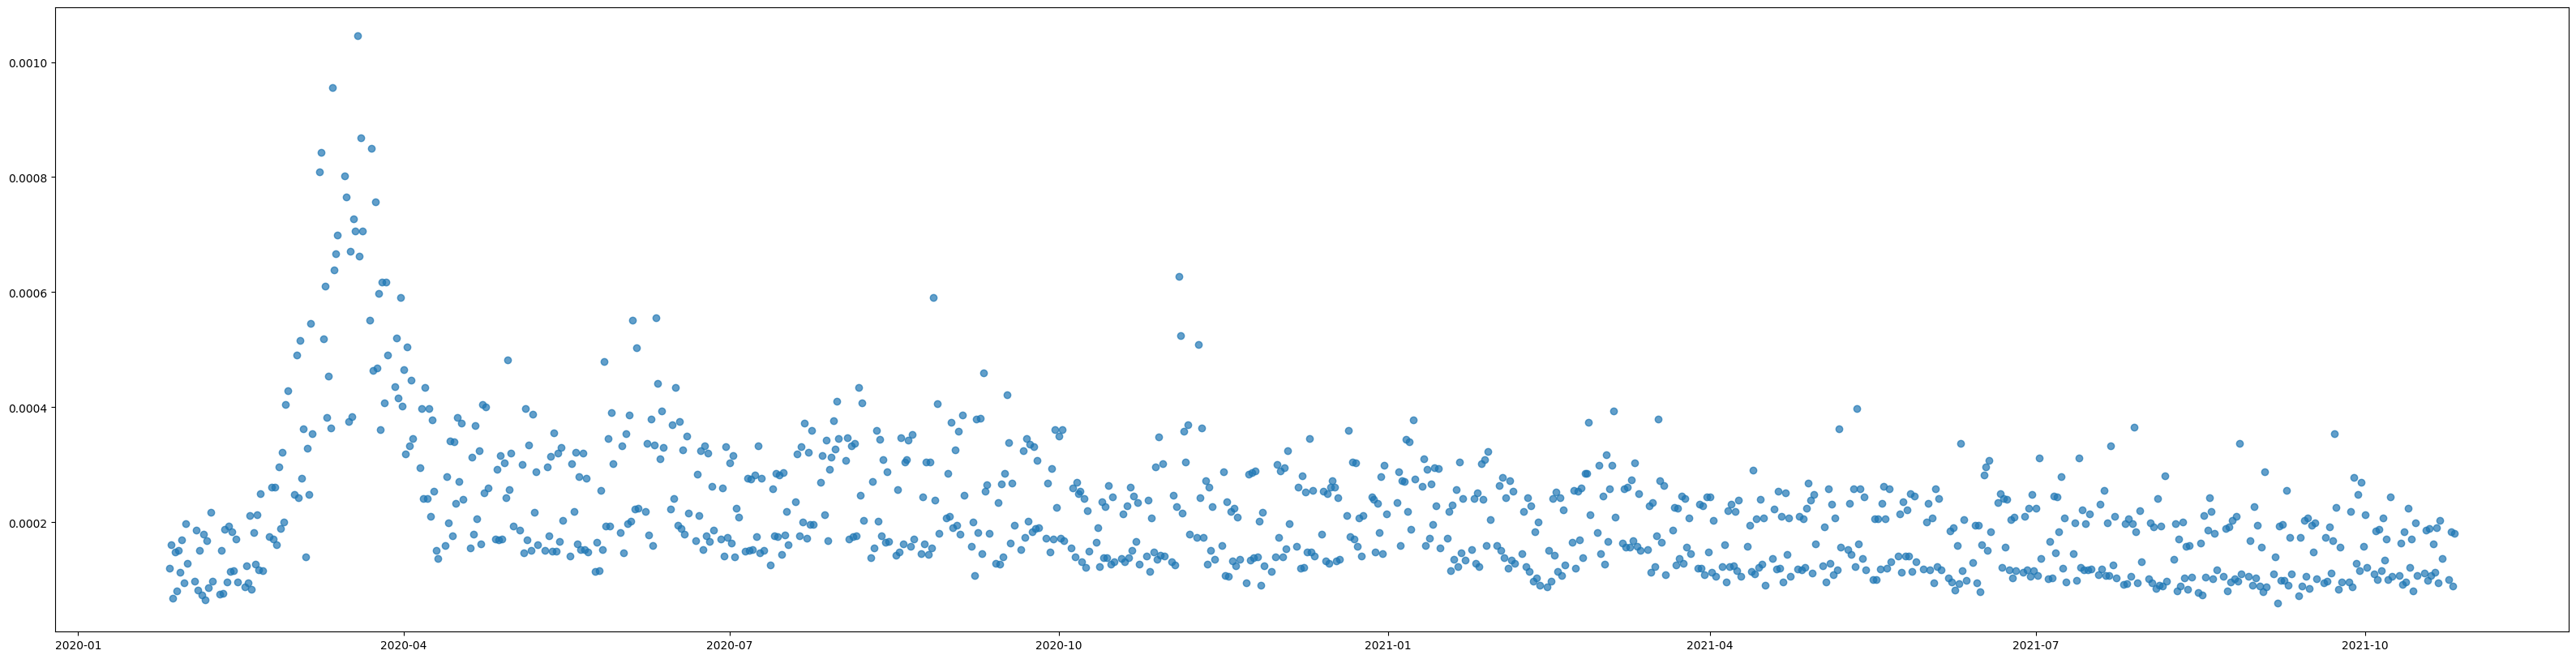

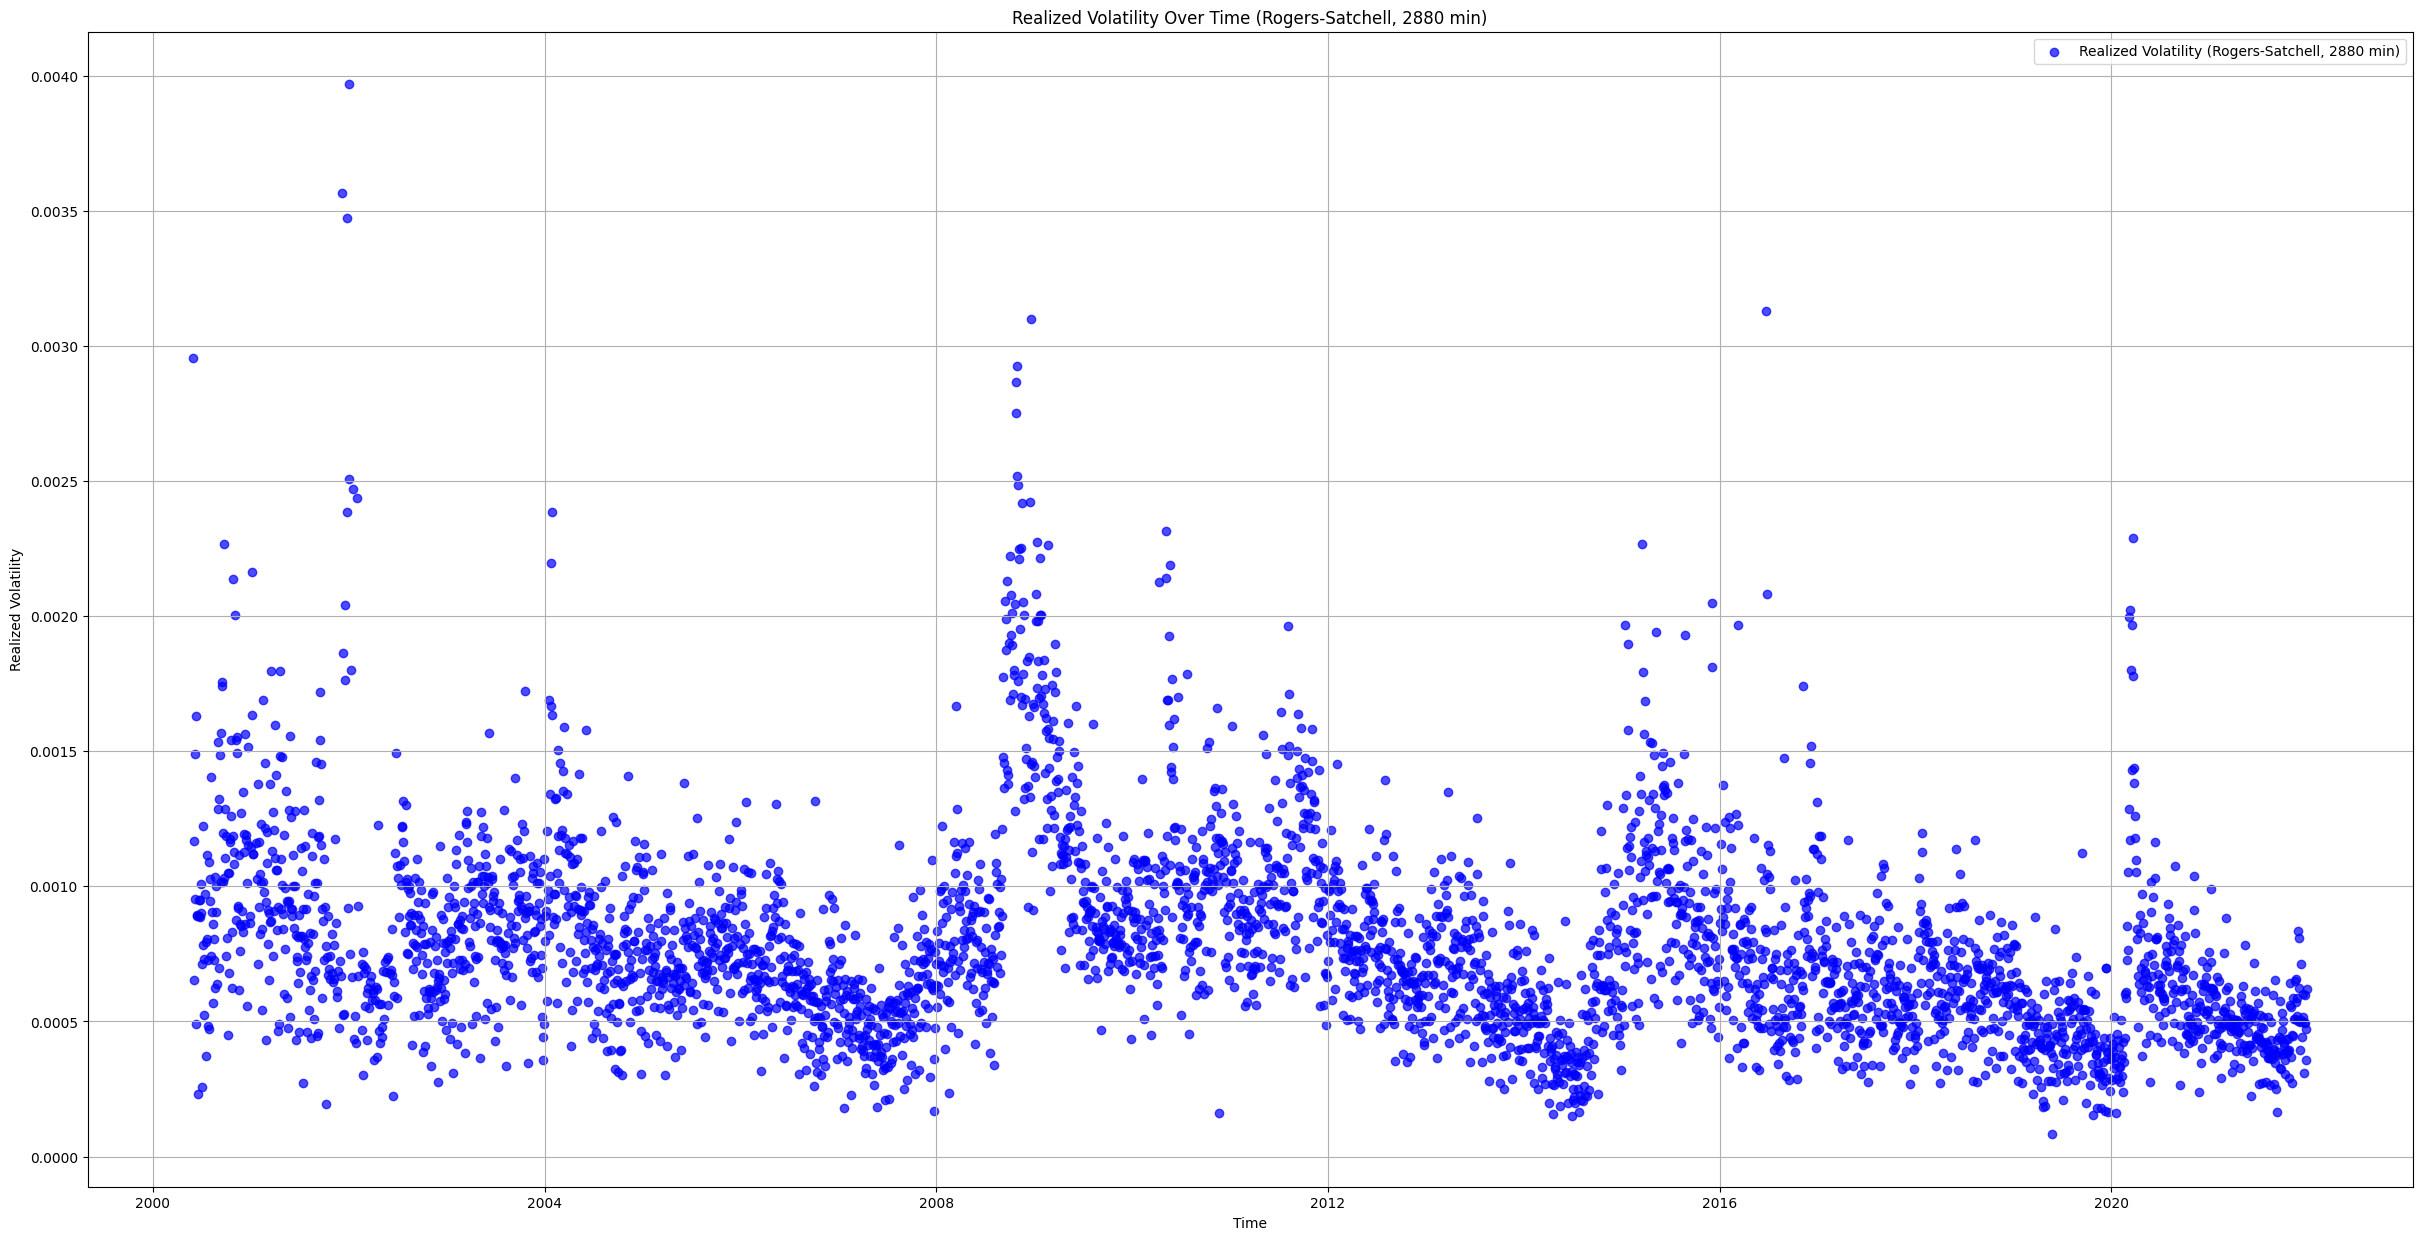

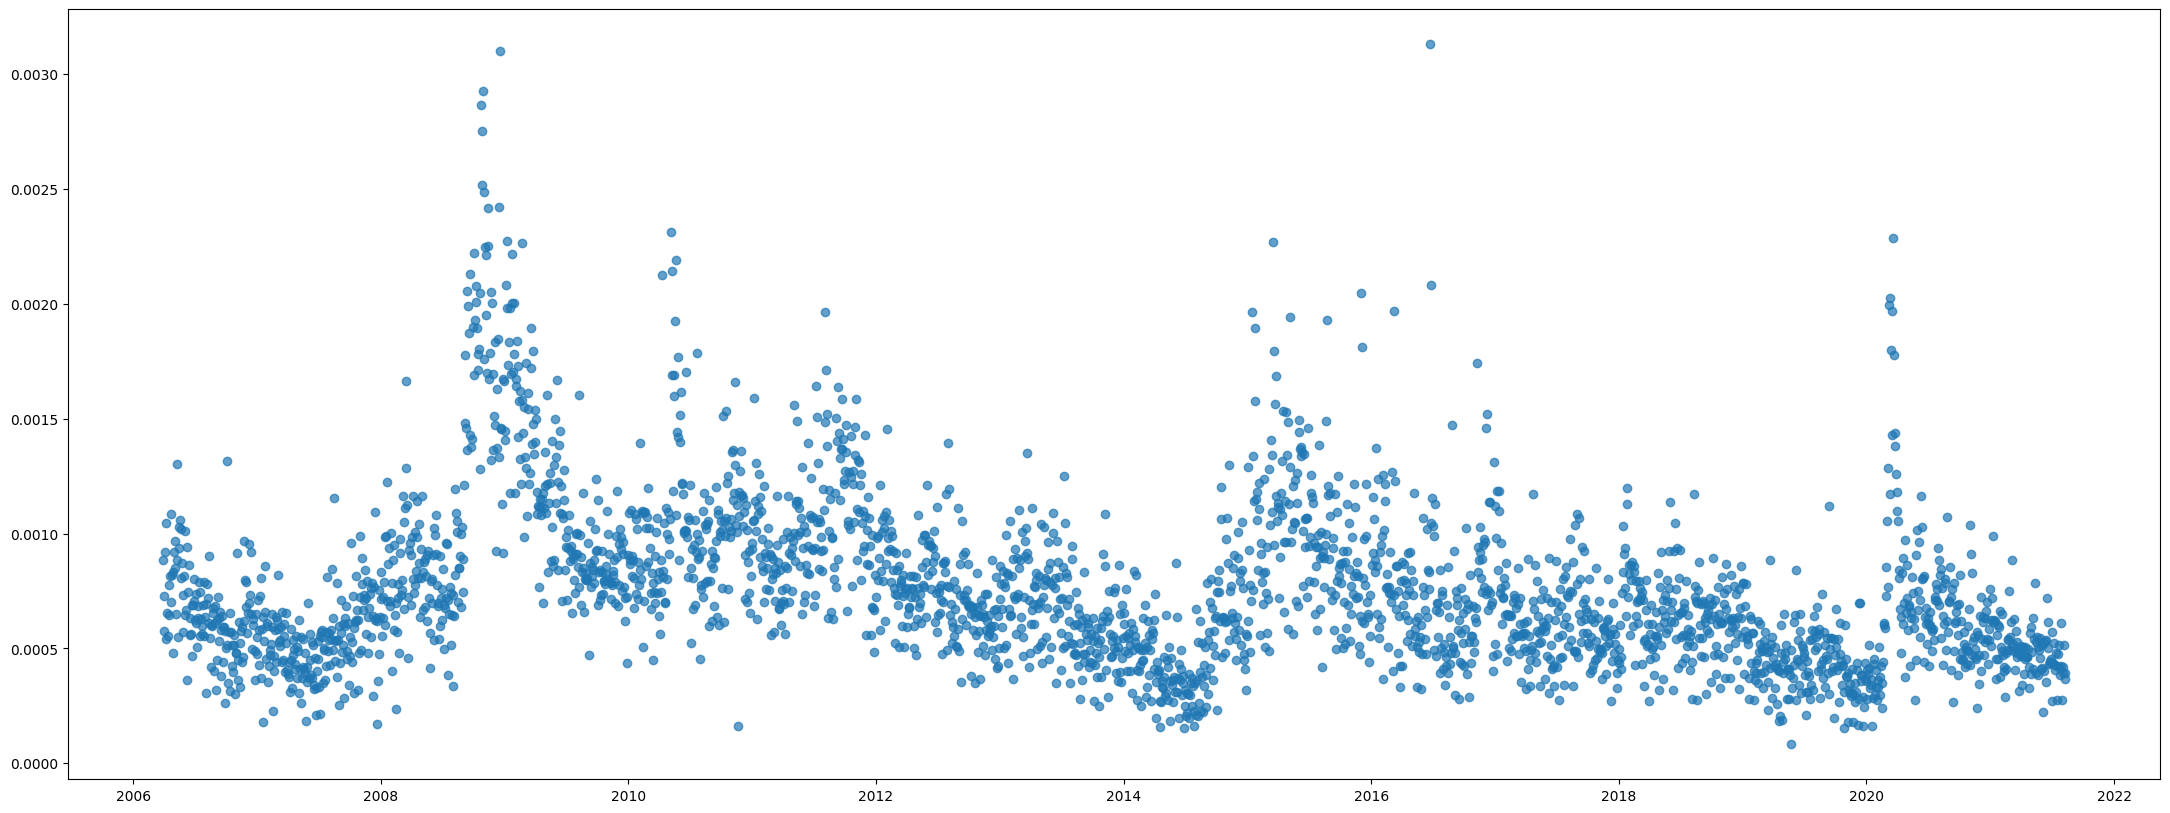

In [6]:
import pandas as pd
import matplotlib.pyplot as plt



# Ensure DateTime is in datetime format
combined_df['DateTime'] = pd.to_datetime(combined_df['DateTime'])

# Step 1: Group by date and sum the indicator column (missing minutes per day)
missing_per_day = combined_df.groupby(combined_df['DateTime'].dt.date)['indicator'].sum()

# Step 2: Identify weekdays (days with less than 400 missing data)
weekdays = missing_per_day[missing_per_day < 400].index

# Step 3: Filter the dataframe to include only weekdays
weekday_df = combined_df[combined_df['DateTime'].dt.date.isin(weekdays)]

# Step 4: Group by hour and sum missing data
missing_per_hour_weekdays = weekday_df.groupby(weekday_df['DateTime'].dt.hour)['indicator'].sum()

# Step 5: Add year-wise grouping for better analysis
missing_per_day_yearly = combined_df.groupby([combined_df['DateTime'].dt.year, combined_df['DateTime'].dt.date])['indicator'].sum()

# --- PLOTS ---

# Plot Step 2: Highlighting weekdays (days with missing data < 400)
plt.figure(figsize=(15, 5))
missing_per_day.plot(kind='bar', color=['blue' if date in weekdays else 'red' for date in missing_per_day.index])
plt.title('Weekdays vs Non-Weekdays Based on Missing Data (All Years)')
plt.xlabel('Date')
plt.ylabel('Number of Missing Minutes')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(['Blue: Weekday (<400 missing)', 'Red: Non-Weekday (>=400 missing)'])
plt.show()

# OPTIONAL: Yearly Breakdown (Missing Data Per Day)
plt.figure(figsize=(15, 6))
for year in sorted(combined_df['DateTime'].dt.year.unique()):
    missing_per_day_yearly.loc[year].plot(label=str(year))
plt.title('Missing Data Per Day (Yearly Comparison)')
plt.xlabel('Date')
plt.ylabel('Missing Data')
plt.xticks(rotation=45)
plt.legend(title="Year")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Plot Step 3: Missing data per weekday across multiple years
plt.figure(figsize=(15, 5))
weekday_missing_data = missing_per_day[weekdays]
weekday_missing_data.plot(kind='bar', color='blue')
plt.title('Missing Data Per Day in Weekdays (All Years)')
plt.xlabel('Date')
plt.ylabel('Missing Data')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Plot Step 4: Missing data per hour on weekdays
plt.figure(figsize=(12, 5))
missing_per_hour_weekdays.plot(kind='bar', color='red')
plt.title('Missing Data Per Hour on Weekdays (All Years)')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Missing Minutes')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

missing_per_day
# Group by month and sum the indicator column (missing minutes per month)
missing_per_month = combined_df.groupby(combined_df['DateTime'].dt.month)['indicator'].sum()

# Plot the bar chart
plt.figure(figsize=(35, 5))
missing_per_month.plot(kind='bar', color='red')
plt.title('Missing Data Per Month')
plt.xlabel('Month')
plt.ylabel('Number of Missing Minutes')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
# We expect to have 4 weekends/ mo. Therefore 4*2*24*60 minutes missing per month = 11,520
print(missing_per_month)
sum(missing_per_month)-(11520*12)
dup_consecutive = combined_df[['Open', 'High', 'Low', 'Close']].eq(combined_df[['Open', 'High', 'Low', 'Close']].shift(-1)).all(axis=1) | \
                  combined_df[['Open', 'High', 'Low', 'Close']].eq(combined_df[['Open', 'High', 'Low', 'Close']].shift(1)).all(axis=1)
dup_df= combined_df[dup_consecutive]
dup_df
60*5*4*12   # if we assume we have an entire hour of duplicates over a year
# Remove duplicated OHLC data
combined_df_clean = combined_df[~dup_consecutive]
combined_df_clean

dup_check = combined_df_clean[['Open', 'High', 'Low', 'Close']].eq(combined_df_clean[['Open', 'High', 'Low', 'Close']].shift(-1)).all(axis=1) | \
                  combined_df_clean[['Open', 'High', 'Low', 'Close']].eq(combined_df_clean[['Open', 'High', 'Low', 'Close']].shift(1)).all(axis=1)
dup_check_df = combined_df_clean[dup_check]
dup_check_df.head(20)

# Step 2: Extract only the duplicate rows for review
dup_check_df = combined_df_clean[dup_check]

# Step 3: Remove the left over duplicate OHLC rows
final_data = combined_df_clean[~dup_check]
final_data

dup_check = final_data[['Open', 'High', 'Low', 'Close']].eq(final_data[['Open', 'High', 'Low', 'Close']].shift(-1)).all(axis=1) | \
                  final_data[['Open', 'High', 'Low', 'Close']].eq(final_data[['Open', 'High', 'Low', 'Close']].shift(1)).all(axis=1)
dup_check_df = final_data[dup_check]
dup_check_df.head(20)
# Ensure 'DateTime' is the index
combined_df_clean.index = pd.to_datetime(combined_df_clean.index)
combined_df_clean['Close'].plot()    ### plot data nicely including years



final_data
data = final_data.copy()
data['Close'].iloc[374920:374950].max()
data['Close'].nlargest(n=5)
max_idx = data['Close'].idxmax()
max_idx
data.loc[max_idx, :] = np.nan

# Plot the 'Close' prices
plt.figure(figsize=(12, 6))
plt.plot(data['DateTime'], data['Close'], label='Close Price', linewidth=1)

# Enhancing the plot aesthetics
plt.title('EUR/USD Close Price Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close Price', fontsize=12)
plt.grid(alpha=0.3)
plt.legend(loc='upper left')
plt.tight_layout()

# Show the plot
plt.show()

# Create a column to identify hourly groups
data['Hour'] = pd.to_datetime(data['DateTime']).dt.floor('h').dt.hour
data
#######   RVOLATILITY CALCULATION   #######

data['Prev_Close'] = data['Close'].shift(1)
data.dropna(subset=['Prev_Close'], inplace=True)


def calculate_rvol(ohlc_data, vol_measure, timeframe, minute_interval):
    """
    Computes realized volatility (rVol) using a selected measure, timeframe, and minute data granularity.

    Parameters:
    - data (pd.DataFrame): A dataframe with 'Open', 'High', 'Low', 'Close' prices indexed by timestamp.
    - vol_measure (str): The volatility measure to use ('Garman-Klass', 'Rogers-Satchell', 'Close-to-Close').
    - timeframe (int): The time window for realized volatility (must be a multiple of 60 minutes).
    - minute_interval (int): The granularity of minute data (1, 5, 10, etc.).

    Returns:
    - rvol_df (pd.DataFrame): A dataframe containing the calculated realized volatility.
    """
    assert timeframe % 60 == 0, "Timeframe must be a multiple of 60 minutes."
    assert minute_interval > 0, "Minute interval must be positive."
    '''
    # Ensure DateTime is set as index and is in datetime format
    data['DateTime'] = pd.to_datetime(data['DateTime'])
    data = data.set_index('DateTime')
    # Step 1: Resample data at the specified `minute_interval` to form proper OHLC bars
    resample_str = f'{minute_interval}T'  # Resampling interval
    ohlc_data = data.resample(resample_str).agg({
        'Open': 'first',
        'High': 'max',
        'Low': 'min',
        'Close': 'last'
    }).dropna()'''

    # Constants
    k = 2 * np.log(2) - 1  # Constant for Garman-Klass

    # Step 2: Compute volatility measures
    if vol_measure == 'Garman-Klass':
        ohlc_data['V'] = 0.5 * (np.log(ohlc_data['High'] / ohlc_data['Low']) ** 2) - k * (np.log(ohlc_data['Close'] / ohlc_data['Open']) ** 2)
    elif vol_measure == 'Rogers-Satchell':
        ohlc_data['Prev_Close'] = ohlc_data['Close'].shift(1)
        ohlc_data.dropna(subset=['Prev_Close'], inplace=True)

        ohlc_data['V'] = (np.log(ohlc_data['High'] / ohlc_data['Prev_Close']) * np.log(ohlc_data['High'] / ohlc_data['Close']) +
                          np.log(ohlc_data['Low'] / ohlc_data['Prev_Close']) * np.log(ohlc_data['Low'] / ohlc_data['Close']))
    elif vol_measure == 'Close-to-Close':
        ohlc_data['Log_Returns'] = np.log(ohlc_data['Close'] / ohlc_data['Close'].shift(1))
        ohlc_data['V'] = ohlc_data['Log_Returns'] ** 2  # Squared log returns for variance
    else:
        raise ValueError("Invalid volatility measure. Choose 'Garman-Klass', 'Rogers-Satchell', or 'Close-to-Close'.")

    # Step 3: Resample based on the specified timeframe
    resample_str_timeframe = f'{timeframe}T'  # 'T' stands for minutes in pandas resampling
    period_counts = ohlc_data.resample(resample_str_timeframe).size()  # Count of data points per timeframe
    rvol_data = ohlc_data.resample(resample_str_timeframe).agg({'V': 'sum'})

    # Adjust by (N-1) for sample variance
    rvol_data['V'] /= (period_counts - 1)

    # Compute realized volatility (square root of variance)
    rvol_data[f'RVol_{timeframe}min_{vol_measure}'] = np.sqrt(rvol_data['V'])

    # Final DataFrame for analysis
    rvol_df = rvol_data[[f'RVol_{timeframe}min_{vol_measure}']]#.dropna()
    rvol_df = rvol_df[rvol_df>0]

    # Step 4: Plot realized volatility as a scatter plot
    plt.figure(figsize=(30, 15))
    plt.scatter(rvol_df.index, rvol_df, label=f'Realized Volatility ({vol_measure}, {timeframe} min)', color='b', alpha=0.7)
    plt.xlabel('Time')
    plt.ylabel('Realized Volatility')
    plt.title(f'Realized Volatility Over Time ({vol_measure}, {timeframe} min)')
    plt.legend()
    plt.grid(True)
    plt.show()

    return rvol_df
def Prepare_data_calc_rvol(data, vol_measure, timeframe, minute_interval, threshold):
    """
    Identifies missing data per resampled timeframe group while considering the minute interval.
    Drops groups where missing data exceeds a specified threshold.

    Parameters:
    - data (pd.DataFrame): A dataframe with 'DateTime' column and OHLC prices.
    - timeframe (int): The time window for resampling (must be a multiple of 60 minutes).
    - minute_interval (int): The granularity of minute data (e.g., 1, 5, 10-minute intervals).
    - threshold (float): The threshold (percentage) of missing data above which the group is dropped.

    Returns:
    - filtered_missing_data_per_group (pd.Series): Series of missing data per timeframe group after filtering.
    - filtered_ohlc_data (pd.DataFrame): The OHLC data grouped into the specified interval, removing groups with excessive missing data.
    """
    assert timeframe % 60 == 0, "Timeframe must be a multiple of 60 minutes."
    assert minute_interval > 0, "Minute interval must be positive."

    # Ensure DateTime is set as index and is in datetime format
    data['DateTime'] = pd.to_datetime(data['DateTime'])
    data = data.set_index('DateTime')

    # Step 1: Resample data at the specified `minute_interval` to form proper OHLC bars
    resample_str = f'{minute_interval}T'  # Resampling interval
    ohlc_data = data.resample(resample_str).agg({
        'Open': 'first',
        'High': 'max',
        'Low': 'min',
        'Close': 'last',
        'Volume': 'sum',
        'indicator': 'sum'  # Sum missing data indicator
    }).dropna()

    # Step 2: Compute expected vs actual counts per timeframe group
    expected_counts = timeframe // minute_interval  # Expected data points per timeframe group
    grouped_counts = ohlc_data.resample(f'{timeframe}T').size()  # Actual data points per group

    # Step 3: Calculate missing data per group (ensure non-negative values)
    missing_data_per_group = (expected_counts - grouped_counts)
    '''
    # Step 4: Plot missing data per group
    plt.figure(figsize=(12, 6))
    missing_data_per_group.plot(kind='bar', color='red', alpha=0.7)
    plt.xlabel('Timeframe Group')
    plt.ylabel('Missing Data Points')
    plt.title(f'Missing Data Points Per {timeframe}-Minute Group (Minute Interval: {minute_interval})')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()'''

    # Step 5: Identify and remove groups where missing data exceeds the threshold
    remove_groups = missing_data_per_group[missing_data_per_group > expected_counts * threshold].index
    filtered_missing_data_per_group = missing_data_per_group.drop(remove_groups)

    # Step 6: Remove those groups from the resampled OHLC data
    filtered_ohlc_data = ohlc_data.drop(remove_groups, errors='ignore')

    #Step 7: Calculate rvols on the filtered data
    r_vol = calculate_rvol(filtered_ohlc_data, vol_measure, timeframe, minute_interval)
    r_vol = r_vol.dropna()
    '''
    # Step 8: Plot missing data per group after threshold filtering
    plt.figure(figsize=(12, 6))
    filtered_missing_data_per_group.plot(kind='bar', color='blue', alpha=0.7)
    plt.xlabel('Timeframe Group')
    plt.ylabel('Missing Data Points')
    plt.title(f'Missing Data Points Per {timeframe}-Minute Group (After Threshold Filtering)')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()'''

    return r_vol#missing_data_per_group, filtered_ohlc_data, r_vol
RS_120m_rvol = Prepare_data_calc_rvol(data, vol_measure = 'Rogers-Satchell', timeframe = 120, minute_interval = 1, threshold = 0.1)
#RS_120_missing_data, data, RS_120m_rvol = Prepare_data_calc_rvol(data, vol_measure = 'Rogers-Satchell', timeframe = 120, minute_interval = 1, threshold = 0.1)  # Choose 'Garman-Klass', 'Rogers-Satchell', or 'Close-to-Close'
RS_120m_rvol.shape
RS_120m_rvol.isna().sum()
sample = RS_120m_rvol[59000:65000].dropna()

plt.figure(figsize = (40,12))
plt.scatter(sample.index , sample, alpha = 0.7)
'''RS_720_missing_data, data,'''
RS_720m_rvol = Prepare_data_calc_rvol(data, vol_measure = 'Rogers-Satchell', timeframe = 720, minute_interval = 5, threshold = 0.2)  # Choose 'Garman-Klass', 'Rogers-Satchell', or 'Close-to-Close'
RS_720m_rvol.describe()
sample_720 = RS_720m_rvol.iloc[11000:12000]
plt.figure(figsize=(40, 10))
plt.scatter(sample_720.index, sample_720.values, alpha=0.7)
#RS_720_missing_data, data, RS_720m_rvol = Prepare_data_calc_rvol(data, vol_measure = 'Rogers-Satchell', timeframe = 720, minute_interval = 5, threshold = 0.1)
#RS_2880_missing_data ,data,
rvol_2880m_rs = Prepare_data_calc_rvol(data, vol_measure='Rogers-Satchell', timeframe=2880, minute_interval= 30, threshold=0.2) # Choose 'Garman-Klass', 'Rogers-Satchell', or 'Close-to-Close'
rvol_2880m_rs.describe()
sample_2880 = rvol_2880m_rs.iloc[1000:3800]

plt.figure(figsize=(27, 10))
plt.scatter(sample_2880.index, sample_2880.values, alpha=0.7)
RS_120m_rvol.isna().sum()
def plot_rvol_histogram(rvol_data, title='Realized Volatility Histogram', bins=100):
    """
    Plots a histogram of realized volatility values.

    Parameters:
    - rvol_data (pd.Series or pd.DataFrame): The realized volatility data.
    - title (str): The title of the plot.
    - bins (int): Number of histogram bins.
    """

    # If DataFrame, extract the first column
    if isinstance(rvol_data, pd.DataFrame):
        rvol_data = rvol_data.iloc[:, 0]

    # Drop NaN values
    #rvol_data = rvol_data.dropna()

    # Drop NaN and inf/-inf
    rvol_data = rvol_data.replace([np.inf, -np.inf], np.nan).dropna()

    # Plot
    plt.figure(figsize=(10, 6))
    plt.hist(rvol_data, bins=bins, edgecolor='k', alpha=0.7)

    # Mean line
    mean_val = rvol_data.mean()
    plt.axvline(x=mean_val, color='green', linestyle='--', label=f'Mean: {mean_val:.4f}')

    # Labels and title
    plt.title(title)
    plt.xlabel('Realized Volatility')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    plt.show()


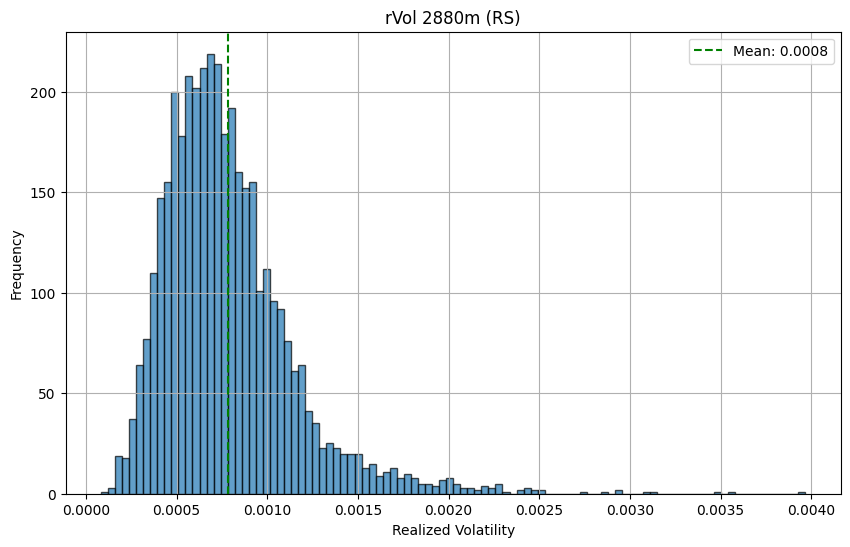

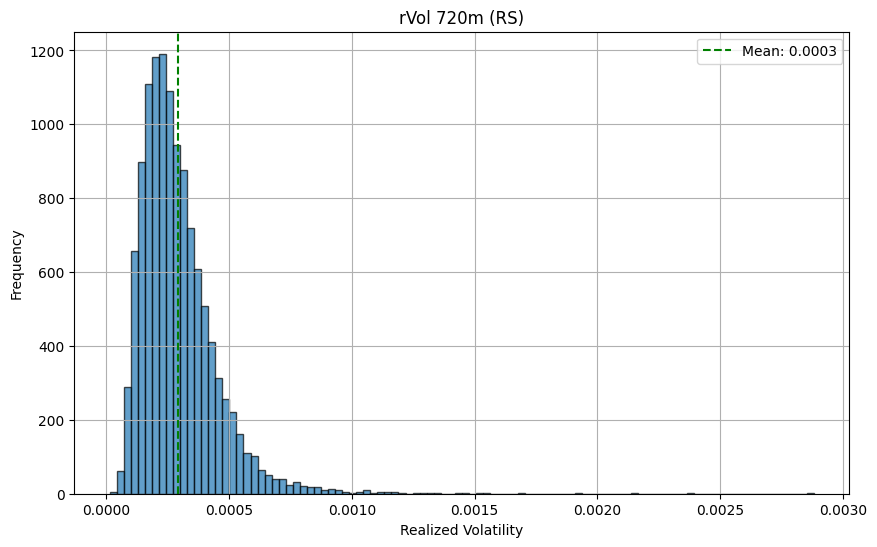

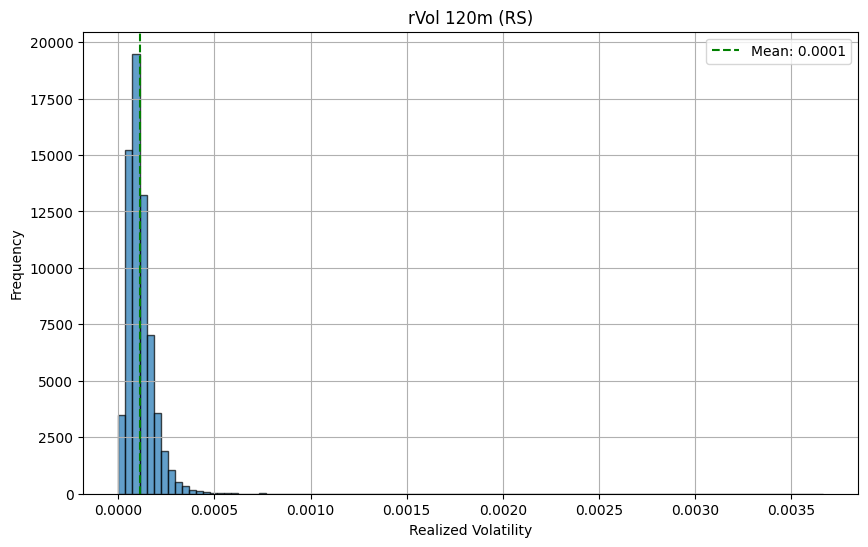

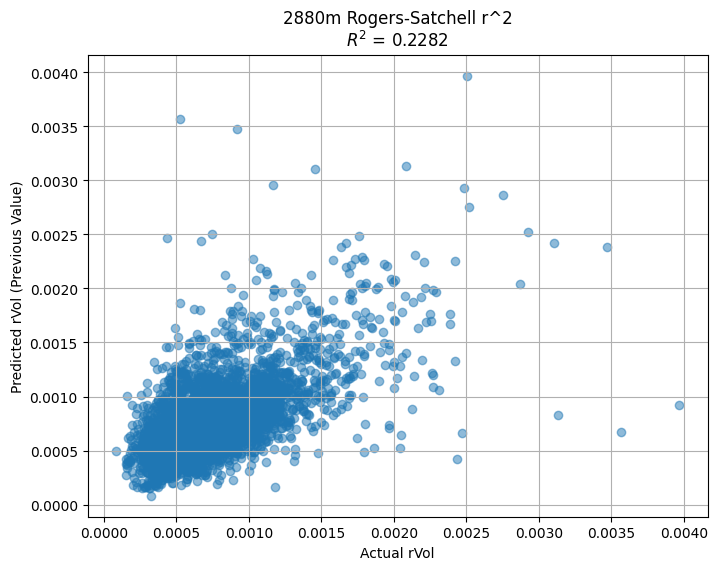

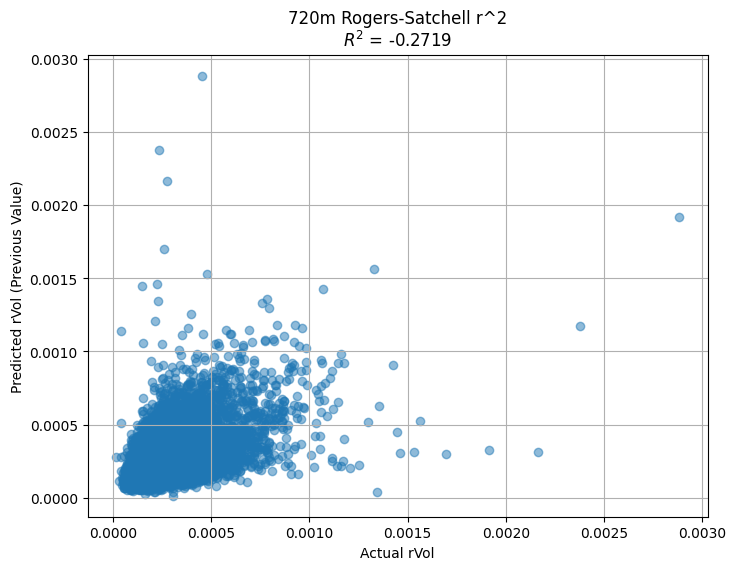

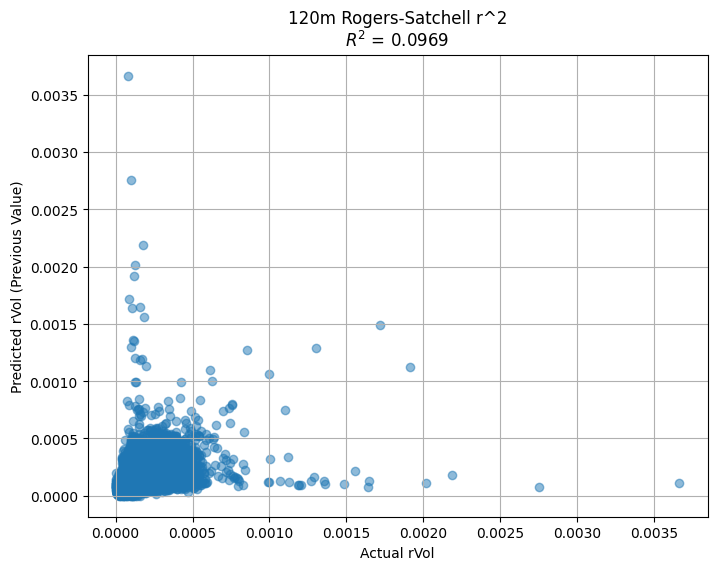

0.09686240712771821

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

def plot_rvol_r2(rvol_series, title='Predicted vs Actual Realized Volatility'):
    """
    Uses the previous rVol value as the prediction and plots R² between predicted and actual rVol.

    Parameters:
    - rvol_series (pd.Series): A time series of realized volatility values.
    - title (str): Title of the plot.
    """

    # Clean the series: remove inf and NaN
    rvol_series = rvol_series.replace([np.inf, -np.inf], np.nan).dropna()

    # Use lag-1 as prediction
    rvol_pred = rvol_series.shift(1).dropna()
    rvol_actual = rvol_series.iloc[1:]

    # Align indices
    rvol_pred = rvol_pred.loc[rvol_actual.index]

    # Final clean: ensure both have no inf or NaN
    mask = (~rvol_actual.isna()) & (~rvol_pred.isna()) & \
           (~np.isinf(rvol_actual)) & (~np.isinf(rvol_pred))
    rvol_actual = rvol_actual[mask]
    rvol_pred = rvol_pred[mask]

    # Check if there is enough data
    if len(rvol_actual) < 2:
        print("Not enough valid data to calculate R².")
        return None

    # R² Score
    r2 = r2_score(rvol_actual, rvol_pred)

    # Plot
    plt.figure(figsize=(8, 6))
    plt.scatter(rvol_actual, rvol_pred, alpha=0.5)
    plt.xlabel('Actual rVol')
    plt.ylabel('Predicted rVol (Previous Value)')
    plt.title(f'{title}\n$R^2$ = {r2:.4f}')
    plt.grid(True)
    plt.show()

    return r2


plot_rvol_histogram(rvol_2880m_rs, title='rVol 2880m (RS)', bins=100)

plot_rvol_histogram(RS_720m_rvol, title='rVol 720m (RS)', bins=100)
plot_rvol_histogram(RS_120m_rvol, title='rVol 120m (RS)', bins=100)
plot_rvol_r2(rvol_2880m_rs, title='2880m Rogers-Satchell r^2')

plot_rvol_r2(RS_720m_rvol, title='720m Rogers-Satchell r^2')

plot_rvol_r2(RS_120m_rvol, title='120m Rogers-Satchell r^2')